In [2]:
import os
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext, SparkContext

SparkContext.setSystemProperty('spark.executor.memory', '2g')
SparkContext.setSystemProperty('spark.driver.cores', '2')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='preprocess_crime_types')

In [1]:
from pyspark.sql.types import *
sqlContext = SQLContext(sc)
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import minmax_scale
import datetime

NameError: name 'SQLContext' is not defined

In [4]:
df = sqlContext.read.csv("/datasets/crimes.csv", header='true')
df.count()

7063815

The dataset has two type attributes:
- Primary type: The primary description of the IUCR code.
- Description: The secondary description of the IUCR code, a subcategory of the primary description.

In [5]:
df.agg(F.countDistinct(F.col("Primary Type")).alias("Number of Primary Types")).show()

+-----------------------+
|Number of Primary Types|
+-----------------------+
|                     35|
+-----------------------+



In [6]:
df.agg(F.countDistinct(F.col("Description")).alias("Number of Descriptions")).show()

+----------------------+
|Number of Descriptions|
+----------------------+
|                   381|
+----------------------+



# Primary Type

In [7]:
#Group by count and sort in descending order before converting it to a pandas dataframe
primary_type = df.groupBy("Primary Type").count().sort(F.col("count").desc())
df_primary_type = primary_type.toPandas().set_index('Primary Type')
df_primary_type.head()

,count
Primary Type,
THEFT,1493935
BATTERY,1291280
CRIMINAL DAMAGE,803333
NARCOTICS,728553
ASSAULT,443107


Plot the distribution of crime types

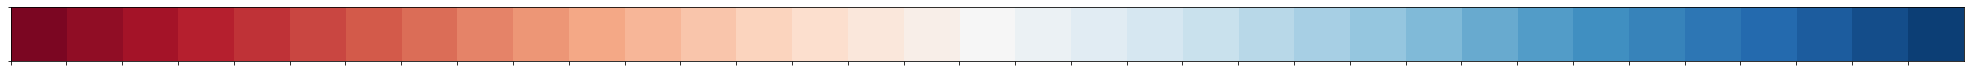

In [8]:
sns.palplot(sns.color_palette("RdBu",len(df_primary_type)))

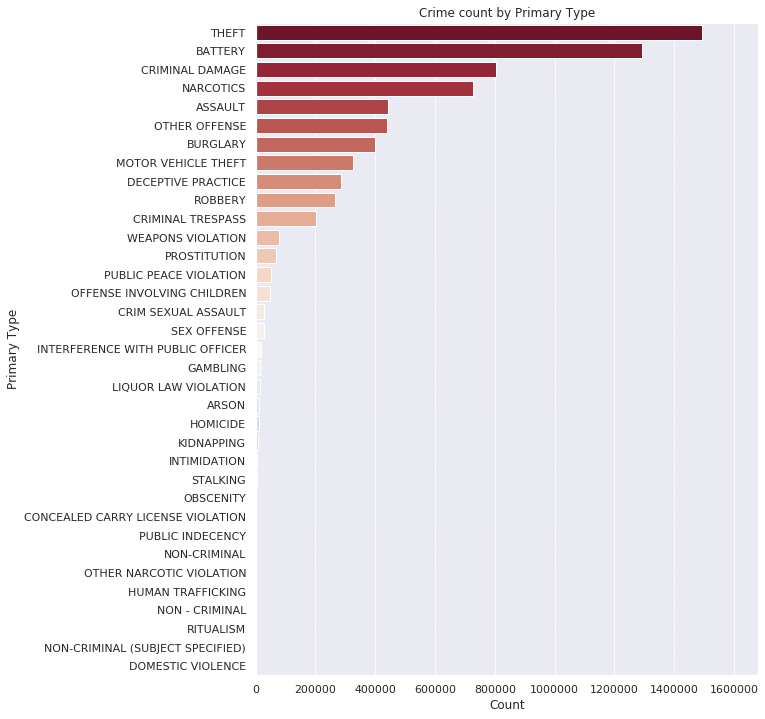

In [9]:
sns.set(rc={'figure.figsize':(9,12)})

ax = sns.barplot(y=df_primary_type.index, 
                 x=df_primary_type['count'], 
                 palette=sns.color_palette("RdBu", len(df_primary_type)),
                 zorder=2,
                 data=df_primary_type)

for tick in ax.get_xticks():
    ax.axvline(x=tick, alpha=0.5, color='#eeeeee', linestyle='dashed', zorder=1)    
    
ax.set_title("Crime count by Primary Type")
ax.set_xlabel('Count')
ax.set_ylabel('Primary Type')
plt.show()

Most of the crimes are represented by a set of few crime types. Lets analyse the percentage of crime types in this dataset

In [10]:
total = sum(df_primary_type["count"].values)
print(df_primary_type["count"].apply(lambda x: (int(x)/total)*100))
print("\n\nThe top 12 types represent",
      round(sum(df_primary_type["count"].apply(lambda x: (int(x)/total)*100)[:12].values),2),
     "% of the crimes in this dataset")

Primary Type
THEFT                                21.149124
BATTERY                              18.280207
CRIMINAL DAMAGE                      11.372509
NARCOTICS                            10.313874
ASSAULT                               6.272913
OTHER OFFENSE                         6.214248
BURGLARY                              5.661176
MOTOR VEHICLE THEFT                   4.603900
DECEPTIVE PRACTICE                    4.060922
ROBBERY                               3.760503
CRIMINAL TRESPASS                     2.854039
WEAPONS VIOLATION                     1.106767
PROSTITUTION                          0.978692
PUBLIC PEACE VIOLATION                0.702156
OFFENSE INVOLVING CHILDREN            0.685961
CRIM SEXUAL ASSAULT                   0.414932
SEX OFFENSE                           0.378988
INTERFERENCE WITH PUBLIC OFFICER      0.240069
GAMBLING                              0.206277
LIQUOR LAW VIOLATION                  0.202837
ARSON                                 0.164274


## Temporal analysis

Examine the behavior of Primary Types over time

In [11]:
df = (df
       .withColumn('Timestamps', F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn("Hour", F.hour("Timestamps"))
       .withColumn("Month", F.month("Day"))
       .withColumn("DayOfWeek", F.dayofweek("Day"))
      )

Rename the types with less than 1% frequence

In [12]:
#Returns Primary Types below a certain threshold
def least_frequent_columns(df,threshold=0.01):
    res = df.groupBy("Primary Type").count()\
                            .withColumn('tot',F.lit(df.count()))\
                            .withColumn('frac',F.expr('count/tot'))\
                            .filter('frac<'+str(threshold))\
                            .select("Primary Type")\
                            .rdd.flatMap(lambda x: x)\
                            .collect()
    return res

In [13]:
@udf(StringType())
def renamer(label):
    if label in lfc:
        return "OTHER CRIMES"
    else:
        return label

In [14]:
lfc = least_frequent_columns(df)

In [15]:
df = (df.withColumn('PrimaryType', renamer(F.col('Primary Type')))\
    .drop("Primary Type")\
    .withColumnRenamed("PrimaryType","Primary Type"))

### Daily

In [16]:
pth = (df.groupBy("Primary Type","Hour")\
       .count()\
       .sort(F.col("Hour"))\
       .groupBy("Primary Type")\
       .pivot("Hour")\
       .agg({"count":"max"})\
       .orderBy('Primary Type'))

In [17]:
df_pth = pth.toPandas().set_index('Primary Type')
df_pth.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Primary Type,,,,,,,,,,,,,,,,,,,,,
ASSAULT,14283,11474,9459,6930,5115,4150,4936,8401,15496,19070,...,27931,29503,26945,26161,26150,25551,24978,23180,20549,17527
BATTERY,64188,61618,55041,44593,31346,21379,18145,22849,34525,40427,...,65101,70617,64312,63747,66857,69034,71004,73416,73991,69599
BURGLARY,17715,9173,8532,8083,7734,9123,13099,21274,26664,23864,...,19239,19560,18644,19707,19663,16775,15373,14886,15644,11880
CRIMINAL DAMAGE,58459,34326,29414,24425,19062,15318,15747,20730,26257,27069,...,28928,33577,35750,41210,46061,45627,48414,50859,54844,43576
CRIMINAL TRESPASS,6954,5298,4342,3427,2756,2414,2714,4565,6795,8016,...,11026,10673,10334,10506,11844,13567,13183,12494,10508,8400


In [18]:
def min_max_scaler(_df):
    for idx, r in _df.iterrows():
        _df.loc[str(idx)] = minmax_scale(r.values)
    return _df

In [19]:
scaled_pth = min_max_scaler(df_pth.copy())

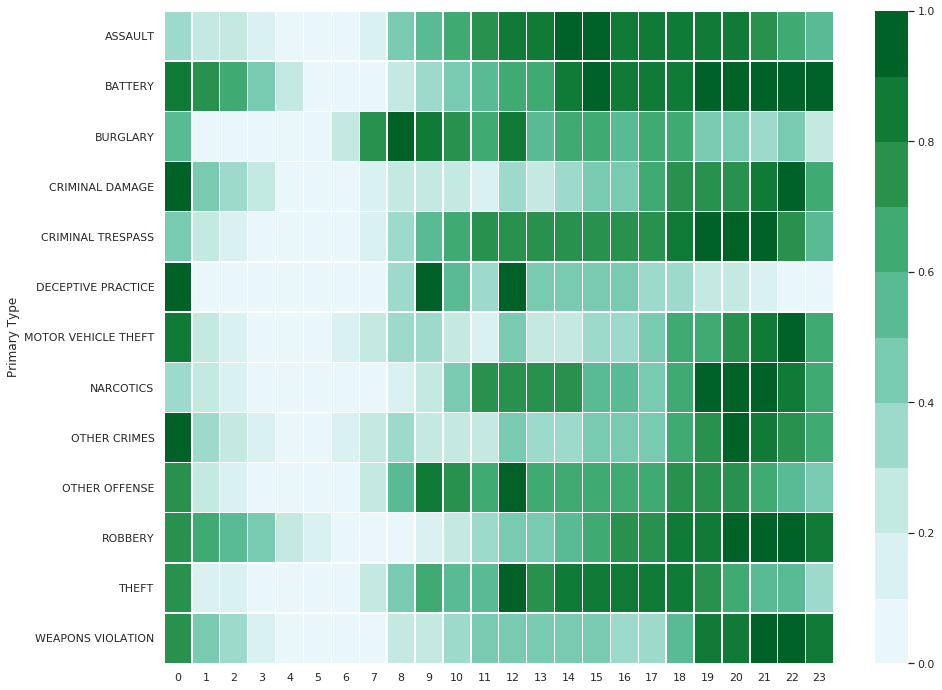

In [20]:
sns.set(rc={'figure.figsize':(15,12)})
ax = sns.heatmap(scaled_pth,
                 linewidth=0.4,
                 cmap = sns.color_palette("BuGn",10)
                )
plt.show()

### Day Of Week

In [21]:
ptdow = (df.groupBy("Primary Type","DayOfWeek")\
       .count()\
       .sort(F.col("DayOfWeek"))\
       .groupBy("Primary Type")\
       .pivot("DayOfWeek")\
       .agg({"count":"max"})\
       .orderBy('Primary Type'))

In [22]:
df_ptdow = ptdow.toPandas().set_index('Primary Type')

In [23]:
df_ptdow.rename(columns={'1': '7', '2': '1','3':'2','4':'3','5':'4','6':'5','7':'6'},inplace=True)

In [24]:
df_ptdow = df_ptdow[[str(i) for i in np.arange(1,8)]] #Reorder

In [25]:
scaled_ptdow = min_max_scaler(df_ptdow.copy())

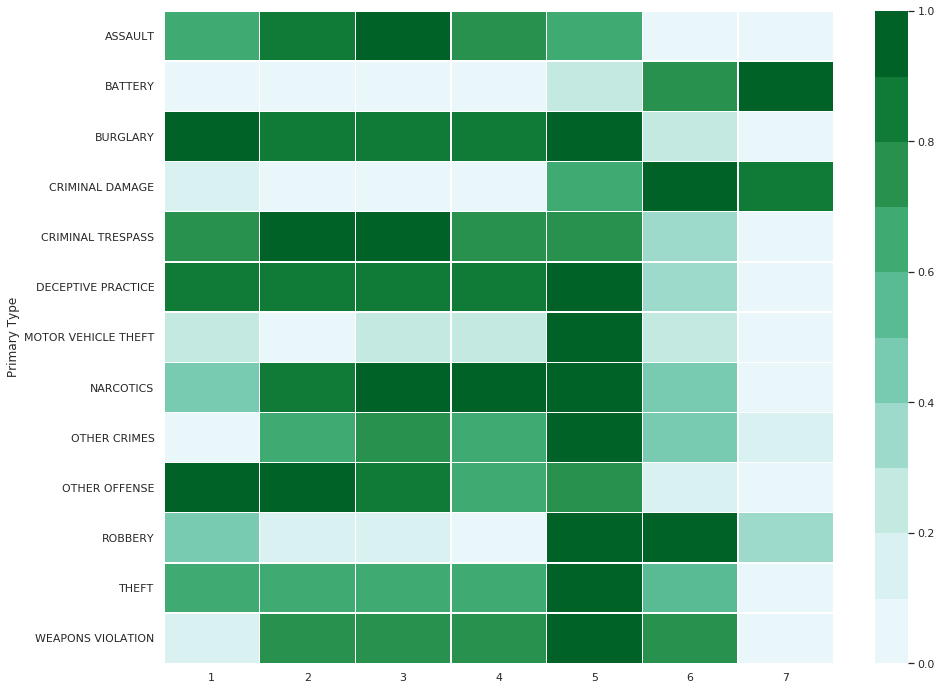

In [74]:
sns.set(rc={'figure.figsize':(15,12)},font_scale = 1)
ax = sns.heatmap(scaled_ptdow,
                 linewidth=0.4,
                 cmap= sns.color_palette("BuGn",10)
                )
plt.show()

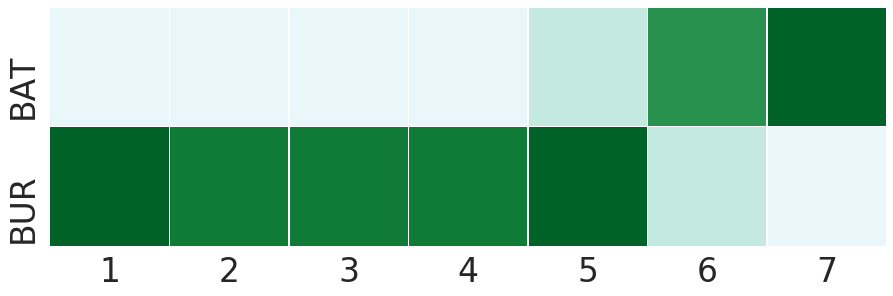

In [71]:
sns.set(font_scale = 3)
ax = sns.heatmap(scaled_ptdow.loc[["BATTERY","BURGLARY"]].rename_axis(None),
                 linewidth=0.4,
                 yticklabels = ["BAT", "BUR"],
                 cmap= sns.color_palette("BuGn",10),
                 cbar=False,
                 square = True
                )

plt.savefig('weekly_types.png')
plt.show()

### Months

In [75]:
ptm = (df.groupBy("Primary Type","Month")\
       .count()\
       .sort(F.col("Month"))\
       .groupBy("Primary Type")\
       .pivot("Month")\
       .agg({"count":"max"})\
       .orderBy('Primary Type'))

In [76]:
scaled_ptm = min_max_scaler(ptm.toPandas().set_index('Primary Type'))

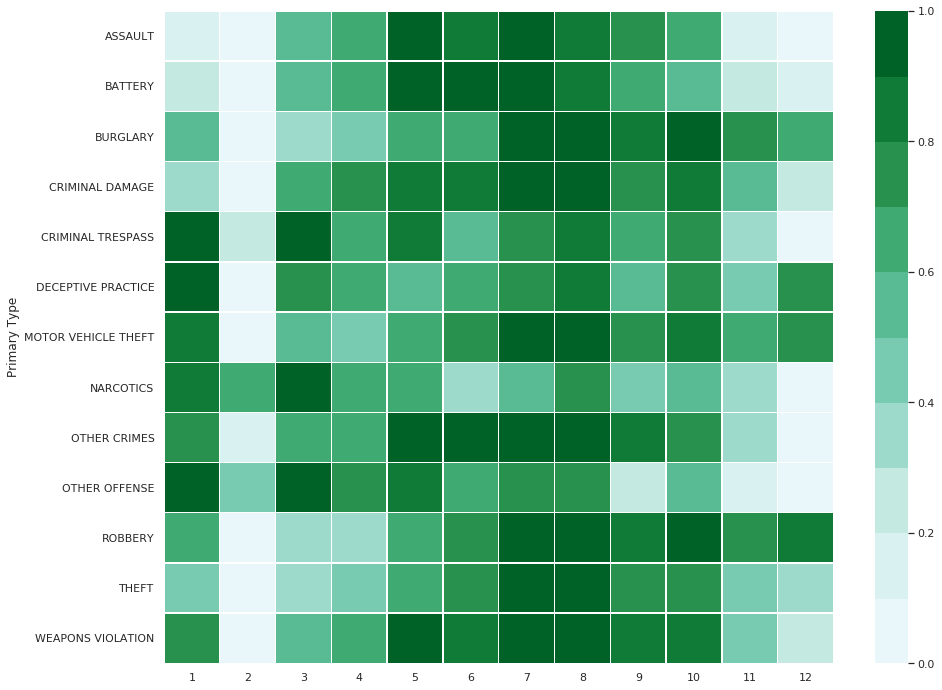

In [77]:
sns.set(rc={'figure.figsize':(15,12)},font_scale = 1)
ax = sns.heatmap(scaled_ptm,
                 linewidth=0.4,
                 cmap= sns.color_palette("BuGn",10)
                )
plt.show()

### Trend analysis of crime types

Go through each type and see whether it has increased or decreased over the past years

In [78]:
daily_pt = (df\
            .groupBy("Day","Primary Type")\
            .count()\
            .groupBy("Day")\
            .pivot("Primary Type")\
            .agg({'count':'max'})\
            .drop("Primary Type","null")\
            .orderBy('Day'))

In [79]:
#Apply MA-120 on each Primary type
MA_120 = Window.orderBy("Day").rowsBetween(-120,0)

daily_pt_cols = daily_pt.schema.names
if "Day" in daily_pt_cols:
    daily_pt_cols.remove("Day")
    
daily_pt_MA = daily_pt
for p in daily_pt_cols:
    daily_pt_MA = daily_pt_MA.withColumn(p +'_120-MA', F.avg(p).over(MA_120))

daily_pt_MA = daily_pt_MA.drop(*daily_pt_cols)

In [80]:
df_pt = daily_pt_MA.toPandas().set_index('Day')
df_pt.head()

,ASSAULT_120-MA,BATTERY_120-MA,BURGLARY_120-MA,CRIMINAL DAMAGE_120-MA,CRIMINAL TRESPASS_120-MA,DECEPTIVE PRACTICE_120-MA,MOTOR VEHICLE THEFT_120-MA,NARCOTICS_120-MA,OTHER CRIMES_120-MA,OTHER OFFENSE_120-MA,ROBBERY_120-MA,THEFT_120-MA,WEAPONS VIOLATION_120-MA
Day,,,,,,,,,,,,,
2001-01-01,70.000000,296.000000,66.000000,233.000000,29.0,92.00,60.000000,97.00,223.0,167.000000,41.000000,413.000000,32.00
2001-01-02,68.000000,219.500000,67.000000,175.500000,32.0,85.00,62.500000,136.00,126.0,134.000000,38.000000,317.000000,20.50
2001-01-03,71.666667,201.333333,63.666667,162.333333,33.0,73.00,65.666667,135.00,99.0,121.333333,42.333333,286.666667,16.00
2001-01-04,68.000000,194.250000,61.500000,155.000000,32.0,65.25,71.000000,136.75,85.5,115.000000,45.500000,275.750000,14.25
2001-01-05,68.000000,191.000000,60.200000,152.400000,31.4,62.80,74.000000,146.40,79.4,110.000000,47.400000,273.600000,12.60


In [81]:
df_pt.isnull().sum()

ASSAULT_120-MA                0
BATTERY_120-MA                0
BURGLARY_120-MA               0
CRIMINAL DAMAGE_120-MA        0
CRIMINAL TRESPASS_120-MA      0
DECEPTIVE PRACTICE_120-MA     0
MOTOR VEHICLE THEFT_120-MA    0
NARCOTICS_120-MA              0
OTHER CRIMES_120-MA           0
OTHER OFFENSE_120-MA          0
ROBBERY_120-MA                0
THEFT_120-MA                  0
WEAPONS VIOLATION_120-MA      0
dtype: int64

<Figure size 1080x864 with 0 Axes>

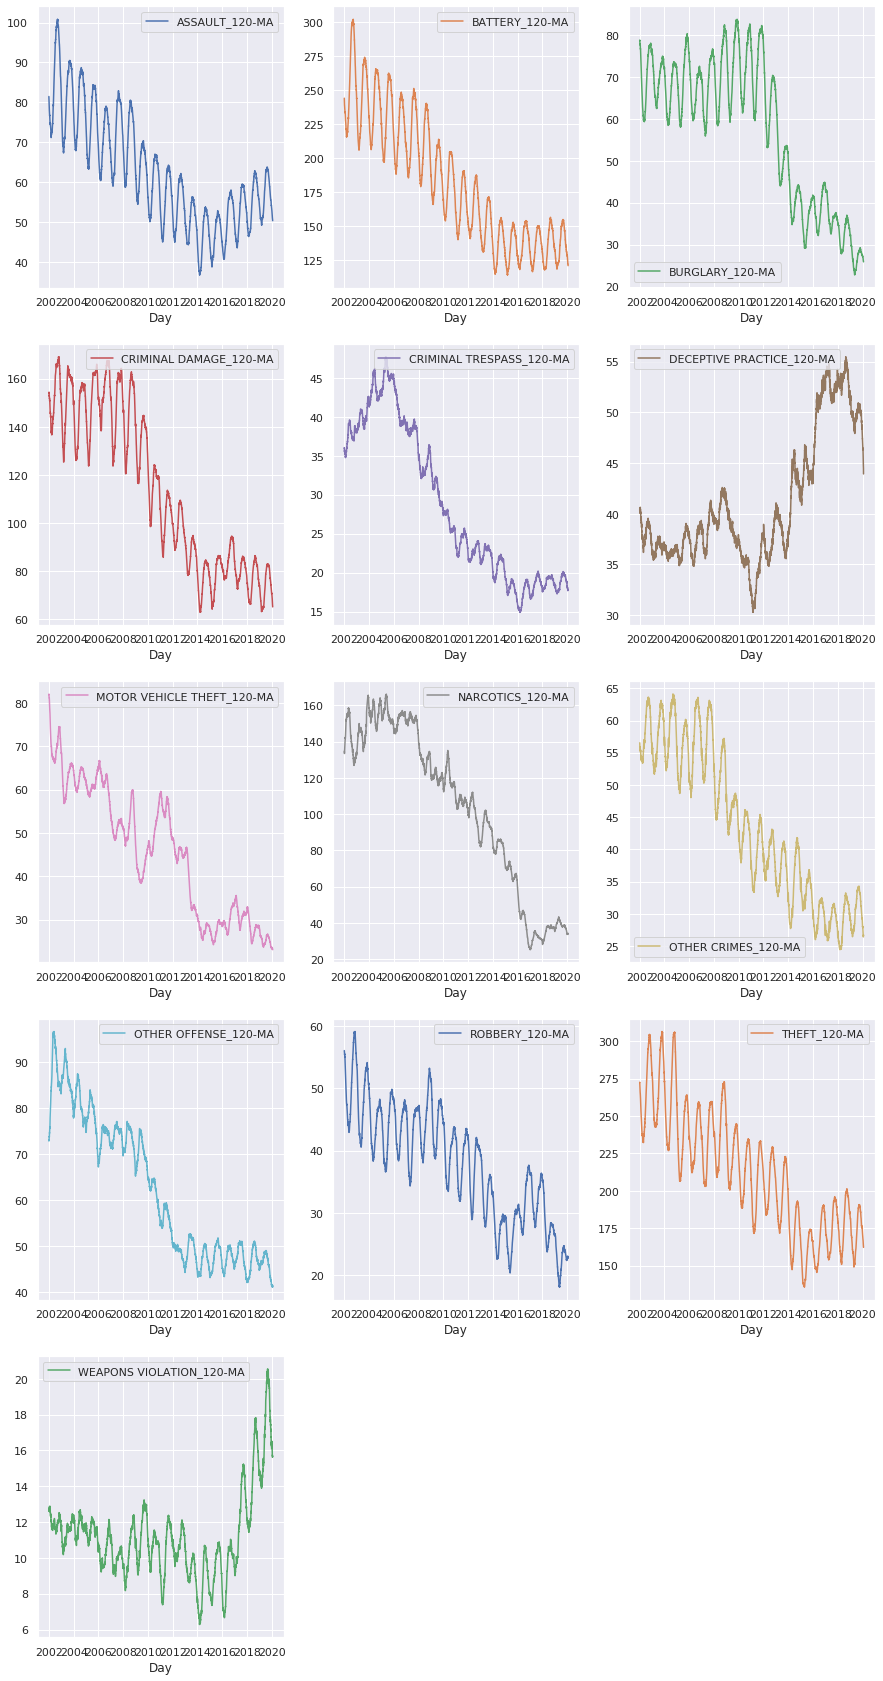

In [82]:
plt.clf()
df_pt[365:].plot(figsize=(15, 30),
                   subplots=True,
                   layout=(-1, 3),
                   sharex=False,
                   sharey=False
                )
plt.show()

Most of them has seasonal patterns (Narcotics not so much). Big rise in weapons vialoation and deceptive practice, while e.g. burglary and criminal trespass have been decreasing a lot over the past few years. Before creating a nicer plot of one increasing and deacreasing example, we apply a 365-MA in order to filter the seasonal terms. We will also apply a minmax scaler because the values of the types are within different ranges.

In [83]:
MA_365 = Window.orderBy("Day").rowsBetween(-365,0)


daily_pt_MA = daily_pt
for p in daily_pt_cols:
    daily_pt_MA = daily_pt_MA.withColumn(p +'_365-MA', F.avg(p).over(MA_365))

daily_pt_MA = daily_pt_MA.drop(*daily_pt_cols)

In [84]:
df_pt = daily_pt_MA.toPandas().set_index('Day')

<Figure size 1080x864 with 0 Axes>

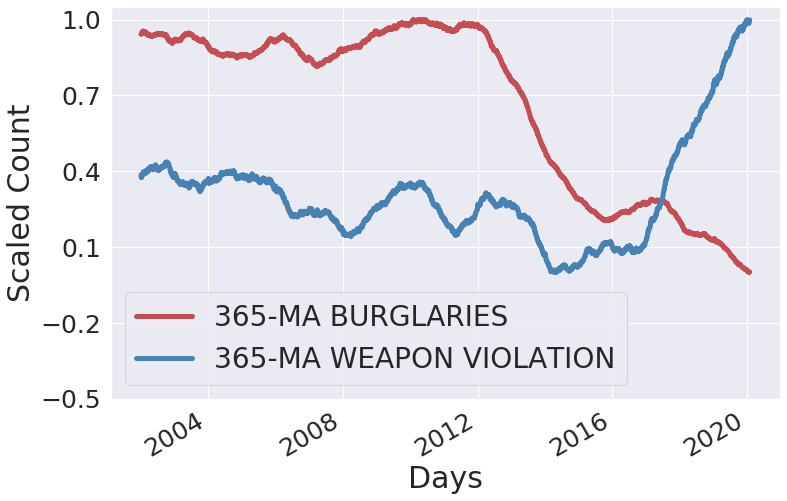

In [85]:
burglaries = df_pt[365:]["BURGLARY_365-MA"]
weapon_vio = df_pt[365:]["WEAPONS VIOLATION_365-MA"]

plt.clf()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111)

ax.plot(burglaries.index, minmax_scale(burglaries.values),linewidth=5, label="365-MA BURGLARIES",c='C3')
ax.plot(weapon_vio.index, minmax_scale(weapon_vio.values),linewidth=5, label="365-MA WEAPON VIOLATION", c='steelblue')

#years = mdates.YearLocator()

years = matplotlib.dates.YearLocator(4)   
months = matplotlib.dates.MonthLocator(4) 
years_fmt = matplotlib.dates.DateFormatter('%Y')


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.format_xdata = matplotlib.dates.DateFormatter('%Y-%m-%d')
ax.grid(True)
fig.autofmt_xdate()
plt.xlabel('Days', fontsize=30)
plt.ylabel('Scaled Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(np.linspace(-.5,1,6),fontsize=25)
plt.legend(fontsize=28, loc='lower left')
plt.savefig('scaled_type.png')
plt.show()